## **Disclaimer!**
This notebook is meant to be used by anyone interested in replicating our model or playing around with the data. In order to access all features, please go to this [Google Drive Folder](https://drive.google.com/drive/folders/1kUTkGI89PJRl0dVy79xIZuH9Qokl9Stq) and store it on your own Google Drive. By clicking on the folder name "Thesis_LucaThoms" and selecting "Add a shortcut to Drive", all necessary files are automatically shared with your main Drive environment without having to download all the data or files individually! After that, simply run all the code as you like.  

## **Setup**

Loading required packages, setting up devices (e.g., cuda), and mounting Google Drive for data/model access

In [1]:
!pip install -q stepwise_regression # Install unavailable package "stepwise_regression"

# Import standard library packages
import os
import json
import random
import time
import cv2
import pickle
import warnings
warnings.filterwarnings("ignore") # to reduce unnecessary output

# Import external packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.figure_factory as ff
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import torchvision
from numpy.linalg import norm
from matplotlib import colors
from scipy.stats import mode
from scipy.stats.mstats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from stepwise_regression.step_reg import forward_regression, backward_regression
from keras.utils import to_categorical
from google.colab import drive
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

# Assign device used for script (e.g., model, processing)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"You are using a {device.type} device.")

You are using a cpu device.


In [2]:
# Define directory to access image folders, labels, and pre-trained models
drive.mount('/content/drive', force_remount = True)
our_data_dir = '/content/drive/MyDrive/Thesis_LucaThoms/'

Mounted at /content/drive


## **Helper Functions**

Various helper functions, assisting with calculations, plotting, padding, scaling, one-hot encoding, and augmentation of tasks.

### **Convenience Functions**

In [3]:
# Calculates how many pixels match between input and output
def accuracy(X_inp, X_out, exclude_zero=False):
    per_diff = []

    # Option to exclude the color zero for accuarcy calculations
    if exclude_zero:
        for i in range(len(X_inp)):
            raw_diff = np.count_nonzero(np.logical_and(X_inp[i] == X_out[i], X_inp[i] != 0))
            (per_diff.append(raw_diff / np.count_nonzero(X_inp[i])) if np.count_nonzero(X_inp[i]) is not 0 else per_diff.append(0))

    else:
        for i in range(len(X_inp)):
            raw_diff = np.count_nonzero(X_inp[i] == X_out[i])
            per_diff.append(raw_diff / X_inp[i].size)

    return per_diff

# Retrieve original input and reconstructed output for a model in evaluation mode.
def validate(model, eval_loader):
    # Put model in evaluation mode and start reconstructions based on latent vector
    model.eval()
    with torch.no_grad():
        for batch_idx, (input, output) in enumerate(eval_loader):
            in_out = torch.cat((input, output), dim=0).to(device)
            z_out, _ = model.encode(in_out)
            out = model.decode(z_out)
            for i in range(len(in_out)):
                X_inp.append(reverse_one_hot_encoder(in_out[i].cpu().numpy()))
                X_out.append(reverse_one_hot_encoder(out[i].cpu().numpy()))
    return X_inp, X_out

# Print fully and partially solved items (100% vs. 95%)
def solved_tasks(X_inp, X_out):
    per_diff = accuracy(X_inp, X_out)

    full_comp = [i for i, e in enumerate(per_diff) if e == 1] # 100%
    nfull_comp = [i for i, e in enumerate(per_diff) if 1 > e > 0.95] # 95%

    print(f'The approach fully solved:')
    print(*full_comp, sep = ', ')
    print(f'The approach nearly solved:')
    print(*nfull_comp, sep = ', ')

    return full_comp

# Splits a list in half and returns each
def split_list(a_list):
    half = len(a_list)//2

    return a_list[:half], a_list[half:]

# Calculates the effect of convolution (amount, kernel, padding, stride) on the image dimensions (w x h)
def convo_eff(w = 30, num = 1, k = 3, p = 0, s = 1):
    for i in range(num):
        w = ((w - k + (2*p))/s) + 1

    return w

# Adds noise to the custom ARC format (empty cells = no color) for denoised Autoencoder
def add_noise(X, noise=0.3):
    X_noise = X[0].unsqueeze(0)
    for i in range(1, len(X)):
        # Clone tensor
        X_clone = X[i].detach().clone()

        # Count the number of 1s in the array
        num_ones = torch.count_nonzero(X_clone).item()

        # Calculate the number of 1s to replace with 0s
        num_to_replace = int(noise * num_ones)

        # Get the indices of the 1s
        indices = torch.argwhere(X_clone == 1).transpose(1,0)

        # Randomly shuffle the indices of the 1s
        idx = torch.randperm(indices[0].nelement())
        indices = indices[:, idx]

        # Replace the first num_to_replace 1s with 0s
        indices_to_replace = indices[:, :num_to_replace]
        X_clone[indices_to_replace[0,:], indices_to_replace[1,:], indices_to_replace[2,:]] = 0

        X_noise = torch.cat((X_noise, X_clone.unsqueeze(0)), dim=0)

    return X_noise

### **Pre-Processing Functions**

In [4]:
# Padding of the ARC matrices for convolutional processing
def padding(X, height=30, width=30, direction='norm'):
    h = X.shape[0]
    w = X.shape[1]

    a = (height - h) // 2
    aa = height - a - h

    b = (width - w) // 2
    bb = width - b - w

    if direction == 'norm':
        X_pad = np.pad(X, pad_width=((a, aa), (b, bb)), mode='constant')

    # Reverse padding for rescaling
    else:
        if height == 30 and width == 30:
            X_pad = X[:, :]
        elif height == 30:
            X_pad = X[:, abs(bb):b]
        elif width == 30:
            X_pad = X[abs(aa):a, :]
        else:
            X_pad = X[abs(aa):a, abs(bb):b]

    return X_pad

# Scaling of the ARC matrices using the Kronecker Product, retaining all the information
def scaling(X, height=30, width=30, direction='norm'):
    h = height/X.shape[0]
    w = width/X.shape[1]
    d = np.floor(min(h, w)).astype(int)

    X_scaled = np.kron(X, np.ones((d, d)))

    if direction == 'norm':
        return padding(X_scaled, height, width).astype(int)

    # Retain information for reverse scaling
    else:
        return d, X_scaled.shape

# Reverse scaling of the ARC matrices for final computations
def reverse_scaling(X_orig, X_pred):
    d, X_shape = scaling(X_orig, 30, 30, direction='rev') # get scaling information
    X_pad_rev = padding(X_pred, X_shape[0], X_shape[1], direction='rev') # reverse padding

    mm = X_shape[0] // d
    nn = X_shape[1] // d
    X_sca_rev = X_pad_rev[:mm*d, :nn*d].reshape(mm, d, nn, d)

    X_rev = np.zeros((mm, nn)).astype(int)
    for i in range(mm):
        for j in range(nn):
            X_rev[i,j] = mode(X_sca_rev[i,:,j,:], axis=None, keepdims=False)[0]

    return X_rev

# One-Hot-Encoding (i.e., dummy coding) of ARC matrices for 10 colors (w x h x color)
def one_hot_encoder(X):
    one_hot = (np.arange(10) == X[..., None]).astype(int)

    return np.transpose(one_hot, axes = [2,0,1])

# Reverse One-Hot-Encoding for easier visualization & final computations
def reverse_one_hot_encoder(X):
    return np.argmax(np.transpose(X, axes=[1,2,0]), axis=-1)

# Replace values in array with new ones from dictionary
def replace_values(X, dic):
    return np.array([dic.get(i, -1) for i in range(X.min(), X.max() + 1)])[X - X.min()]

# Convert ARC grids into numpy arrays
def get_all_matrix(X_full):
    X_fill = []
    for X_task in X_full:
        for X_single in X_task:
            X_fill.append(np.array(X_single))

    return X_fill

# Apply scaling, padding, and one-hot-encoding to arrays to get finalized grids
def get_final_matrix(X_full, stage="train"):
    if stage != "train":
        X_full = get_all_matrix(X_full)

    X_full_mat = []
    for i in range(len(X_full)):
        X_sca = scaling(X_full[i], 30, 30)
        X_one = one_hot_encoder(X_sca)
        X_full_mat.append(X_one)

    return X_full_mat

# Augment color of grids: randomly assign new colors to each color within a grid (creates 9 copies of original)
def augment_color(X_full, y_full):
    X_flip = []
    y_flip = []
    for X, y in zip(X_full, y_full):
        X_rep = np.tile(X, (10, 1, 1))
        X_flip.append(X_rep[0])
        y_rep = np.tile(y, (10, 1, 1))
        y_flip.append(y_rep[0])
        for i in range(1, len(X_rep)):
            rep = np.arange(10)
            orig = np.arange(10)
            np.random.shuffle(rep)
            dic = dict(zip(orig, rep))
            X_flip.append(replace_values(X_rep[i], dic))
            y_flip.append(replace_values(y_rep[i], dic))

    return X_flip, y_flip

# Augment orientation of grids: randomly rotates certain grids by 90, 180, or 270 degrees
def augment_rotate(X_full, y_full):
    X_rot = []
    y_rot = []
    for X, y in zip(X_full, y_full):
        k = random.randint(0, 4)
        X_rot.append(np.rot90(X, k))
        y_rot.append(np.rot90(y, k))

    return X_rot, y_rot

# Midpoint mirroring of grids: Creates copies of grids and mirrors at midpoint the left side
def augment_mirror(X_full, y_full):
    X_mir = []
    y_mir = []
    for X, y in zip(X_full, y_full):
        X_mir.append(X)
        y_mir.append(y)

        X_rep = X.copy()
        n = X_rep.shape[1]
        for i in range(n // 2):
            X_rep[:, n - i - 1] = X_rep[:, i]

        y_rep = y.copy()
        n = y_rep.shape[1]
        for i in range(n // 2):
            y_rep[:, n - i - 1] = y_rep[:, i]

        X_mir.append(X_rep)
        y_mir.append(y_rep)

    return X_mir, y_mir

# Combines array creation, augmentation, and preprocessing (e.g., scaling)
def preprocess_matrix(X_full, y_full, aug=[True, True, True]):
    X_full = get_all_matrix(X_full)
    y_full = get_all_matrix(y_full)

    if aug[0]:
        print("Augmentation: Random Color Flipping")
        X_full, y_full = augment_color(X_full, y_full)

    if aug[1]:
        print("Augmentation: Random Rotation")
        X_full, y_full = augment_rotate(X_full, y_full)

    if aug[2]:
        print("Augmentation: Midpoint Mirroring")
        X_full, y_full = augment_mirror(X_full, y_full)

    X_full = get_final_matrix(X_full)
    y_full = get_final_matrix(y_full)

    return X_full, y_full

### **Visualization Functions**

In [5]:
# Visualize one item
def plot_one(task, ax, i, train_or_test, input_or_output='!'):
    cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)

    if input_or_output == '!':
        input_matrix = task
    else:
        input_matrix = task[train_or_test][i][input_or_output]

    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' ' + input_or_output, size='small')

# Visualize entire item
def plot_task(task, idx):
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(2.5*num_train,2.5*2))
    for i in range(num_train):
        plot_one(task, axs[0,i], i, 'train', 'input')
        plot_one(task, axs[1,i], i, 'train', 'output')
    plt.tight_layout()
    plt.show()

    num_test = len(task['test'])
    num_outp = len(task['test'][0])
    fig, axs = plt.subplots(2, num_test, figsize=(2.5*num_test,2.5*2))
    if num_test == 1:
        plot_one(task, axs[0], 0, 'test', 'input')
        if num_outp > 1:
            plot_one(task, axs[1], 0, 'test', 'output')
    else:
        for i in range(num_test):
            plot_one(task, axs[0,i], i, 'test', 'input')
            plot_one(task, axs[1,i], i, 'test', 'output')
    plt.tight_layout()
    plt.show()

# Plot random ARC item
def plot_ARC(example_num = None, path = 'training'):
    idx = random.randint(0, 99) if example_num is None else example_num

    task_file = f'{eval(path + "_path")}{(eval(path + "_tasks_files"))[idx]}'
    with open(task_file, 'r') as f:
        example = json.load(f)

    plot_task(example, idx)

# Visualize accuracy across processed items in scatterplot with average line
def plot_pix_acc(X_inp, X_out, exclude_zero=False):
    per_diff = accuracy(X_inp, X_out, exclude_zero)
    m = np.mean(per_diff)

    fig, ax = plt.subplots(figsize=(11,5))
    plt.plot(per_diff, color='steelblue', marker='.', linewidth=0)
    plt.axhline(m, xmax = len(per_diff), color='firebrick')
    plt.title(f'Accuracy ofn (Tasks: {len(per_diff)})', size='medium')
    plt.xlabel('Item')
    plt.ylabel('Correct Pixel (%)')
    plt.text(len(per_diff)/2, m+0.01, f'{(m*100).round(2)}%', size='medium', weight='bold')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
    plt.ylim(-0.01, 1.01)
    plt.margins(x=0.01)
    plt.show()
    print(f'Number of 100% Correct: {per_diff.count(1)}')
    print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in per_diff)}')
    print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in per_diff)}')
    print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in per_diff)}')

# Visualize heatmap of individually solved pixels
def plot_pix_heatmap(X_inp, X_out):
    pix_diff = []
    for i in range(len(X_inp)):
        pix_diff.append(X_inp[i] == X_out[i])

    pix_sum = np.sum(pix_diff, axis=0)

    fig, ax = plt.subplots(figsize=(5,5))
    heatmap = sns.heatmap(pix_sum, cmap='inferno_r', square=True) # oder viridis_r
    plt.title('Accuracy of Individual Pixel Reconstruction', size='medium', y=1.04)
    plt.text(0.2, 32, f'Number of 100% Correct Pixels: {np.count_nonzero((pix_sum == len(X_inp)))}', size='medium')
    plt.axis('off')
    plt.show()

## **Load Data**

Loading in the JSON files containing the raw tasks. Tasks are encoded as matrices divided into train/test and input/output sections, containing numbers 0-9 which describe the color palette (e.g., red, orange). The below code makes use of this internal structure to access the train and test data in separate objects.

In [6]:
# Define the three possible data pathways
training_path = f'{our_data_dir}Data/data_training/'
evaluation_path = f'{our_data_dir}Data/data_evaluation/'
concept_path = f'{our_data_dir}Data/data_concept/'

# Store the sorted item names accordingly
training_tasks_files = sorted(os.listdir(training_path))
evaluation_tasks_files = sorted(os.listdir(evaluation_path))
concept_tasks_files = sorted(os.listdir(concept_path))

In [7]:
# Load the data into the objects X_test, y_test, X_train, y_train
focus = "evaluation" #  Define dataset to use for the rest of the script: "training", "evaluation", "concept"

# Load items from file list and open JSON files
focus_tasks = []
for task_file in eval(focus + "_tasks_files"):
    with open(f'{eval(focus + "_path")}{task_file}', 'r') as f:
        task = json.load(f)
        focus_tasks.append(task)

# train: train (example) inputs (X) and output (y)
# test: test inputs (X) and output (y)
X_test, y_test, X_train, y_train = [[] for _ in range(4)]

# Distinguish between train (example) and test grids (input vs output)
for task in focus_tasks:
    Xs_test, ys_test, Xs_train, ys_train = [[] for _ in range(4)]

    for pair in task["test"]:
        Xs_test.append(pair["input"])
        ys_test.append(pair["output"])

    for pair in task["train"]:
        Xs_train.append(pair["input"])
        ys_train.append(pair["output"])

    X_test.append(Xs_test)
    y_test.append(ys_test)
    X_train.append(Xs_train)
    y_train.append(ys_train)

# Reduce test inputs to one task for later model evaluation
test_item = 0 # e.g. ConceptARC test item No.2 would be here "1"
for i in range(len(X_test)):
    if len(X_test[i]) > 1:
        X_test[i] = [X_test[i][test_item]]
        y_test[i] = [y_test[i][test_item]]

# Example
X_test[3]

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [7, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [7, 0, 8, 8, 0, 6, 0, 0, 0, 0],
  [7, 0, 8, 8, 0, 6, 0, 3, 3, 0],
  [7, 0, 8, 8, 0, 6, 0, 3, 3, 0]]]

## **Exploration**

Exploring the features of the tasks visually: Means, Distributions, Skews.

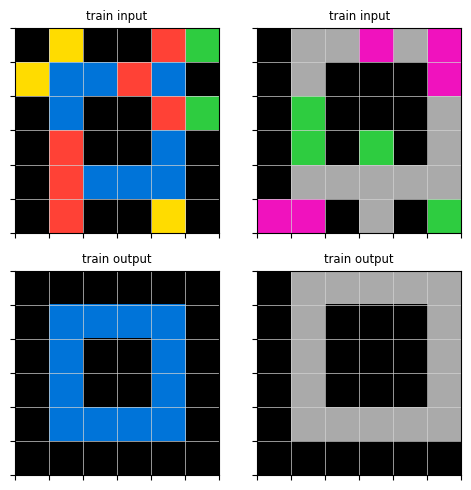

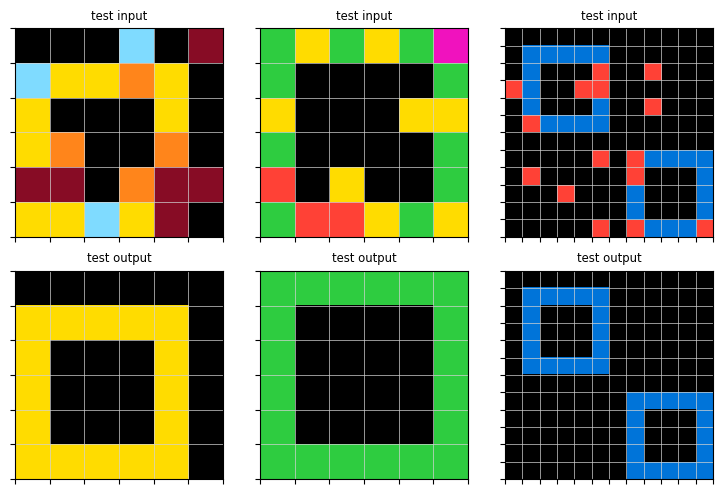

In [ ]:
# Plot chosen items
matrices = get_all_matrix(X_test)

plot_ARC(29, path = "concept")

In [ ]:
# Plot distribution of mean colors
means = [np.mean(matrix) for matrix in matrices]
fig = ff.create_distplot([means], group_labels=["Means"], colors=["green"])
fig.update_layout(title_text="Distribution of matrix mean values")

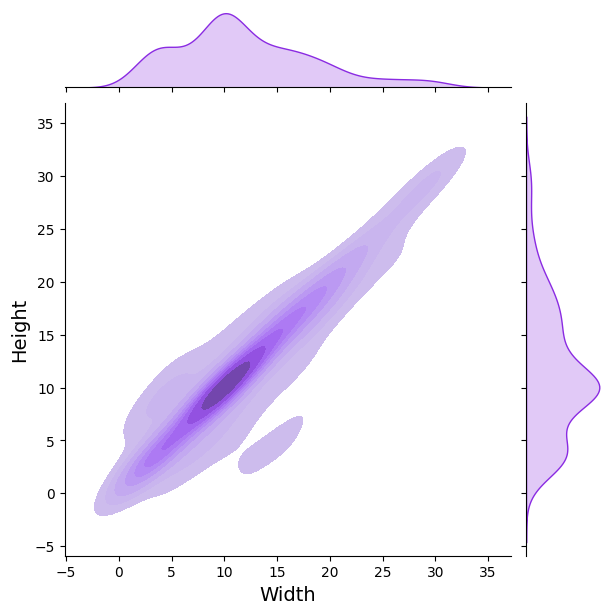

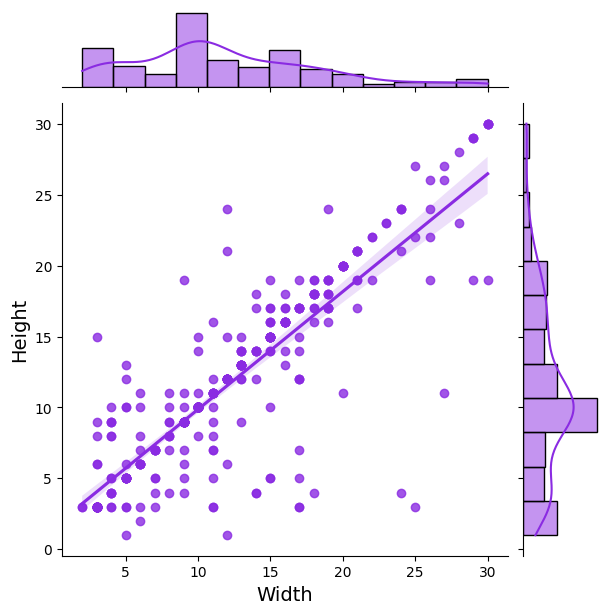

In [ ]:
# Plot joint plot of item dimensions: scatter plot, density plot, distribution plot
heights = [np.shape(matrix)[0] for matrix in matrices]
widths = [np.shape(matrix)[1] for matrix in matrices]

plot = sns.jointplot(x=widths, y=heights, kind="kde", fill=True, thresh = 0.09, color="blueviolet")
plot.set_axis_labels(xlabel="Width", ylabel="Height", fontsize=14)
plt.show(plot)

plot = sns.jointplot(x=widths, y=heights, kind="reg", color="blueviolet")
plot.set_axis_labels(xlabel="Width", ylabel="Height", fontsize=14)
plt.show(plot)

## **PyTorch Dataset**

Preparing the data for the PyTorch framework, applying pre-processing (e.g., scaling, one-hot encoding, padding) and augmentations (e.g., color_flip, rotation).


In [8]:
# PyTorch Dataset Framework: Custom processing of data (incl. Augmentations, Padding)
class ARCDataset(Dataset):
    def __init__(self, X, y, stage="train", aug=[True, True, True]):
        self.stage = stage

        if self.stage == "train":
            self.X, self.y = preprocess_matrix(X, y, aug)
        else:
            self.X = get_final_matrix(X, self.stage)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        inp = self.X[idx]
        inp = torch.tensor(inp, dtype=torch.float32)

        if self.stage == "train":
            outp = self.y[idx]
            outp = torch.tensor(outp, dtype=torch.float32)
            return inp, outp
        else:
            return inp

In [9]:
# Defining loaders function to ease data preparation
def data_load(X_train, y_train, stage="train", aug=[False, False, False], batch_size=1, shuffle=False):
    # Define what augmentations are applied, batch size, and if shuffling is desired

    data_set = ARCDataset(X_train, y_train, stage=stage, aug=aug)
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=shuffle)
    del data_set

    return data_loader

Augmentation: Random Color Flipping
Augmentation: Random Rotation
Augmentation: Midpoint Mirroring


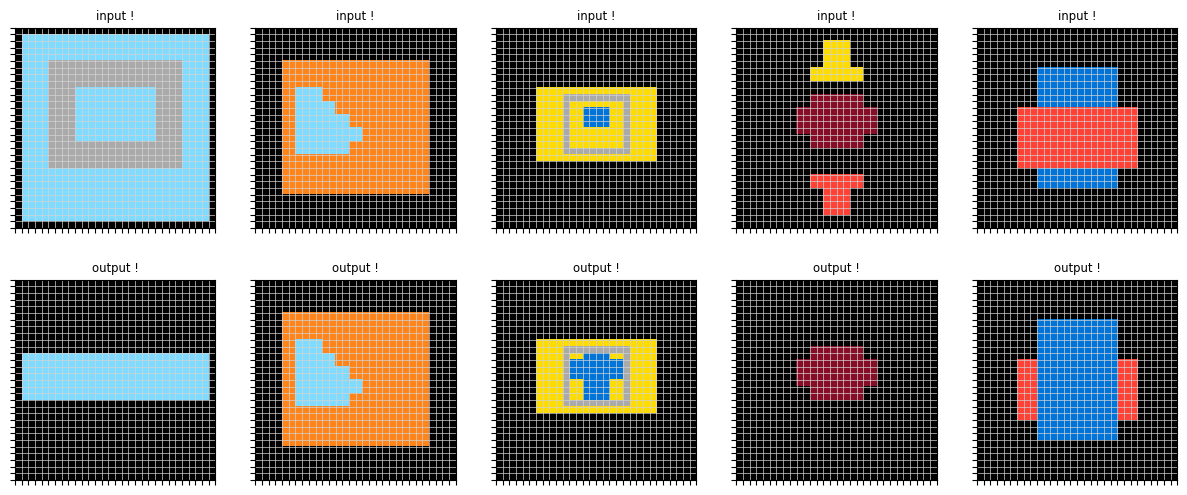

In [ ]:
# Showcase Padding, One-Hot Encoding, Dimensionality, and Augmentations
train_loader = data_load(X_train, y_train, aug=[True, True, True], shuffle=True)
# e.g., all augmentations are applied

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    idx = random.randrange(len(train_loader.dataset.X)) # a random grid is chosen
    plot_one(reverse_one_hot_encoder(train_loader.dataset.X[idx]), axs[0,i], i, 'input')
    plot_one(reverse_one_hot_encoder(train_loader.dataset.y[idx]), axs[1,i], i, 'output')

## **Variational Autoencoder**
Outlines the VAE architecture (modifiable), including encoder, decoder, and probabilistic sampling of latent representation.

In [10]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, img_channels=10, feature_dim=[128, 2, 2], latent_dim=128):
        super(VariationalAutoencoder, self).__init__()

        self.f_dim = feature_dim
        kernel_vae = 4
        stride_vae = 2

        # Initializing the convolutional layers and 2 full-connected layers for the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=img_channels,
                      out_channels=128,
                      kernel_size=kernel_vae,
                      stride=stride_vae),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=kernel_vae,
                      stride=stride_vae),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=kernel_vae,
                      stride=stride_vae),
            nn.LeakyReLU())
        self.fc_mu = nn.Linear(np.prod(self.f_dim), latent_dim)
        self.fc_var = nn.Linear(np.prod(self.f_dim), latent_dim)

        # Initializing the fully-connected layer and convolutional layers for decoder
        self.dec_inp = nn.Linear(latent_dim, np.prod(self.f_dim))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=128,
                               kernel_size=kernel_vae,
                               stride=stride_vae),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=128,
                               kernel_size=kernel_vae,
                               stride=stride_vae),
            nn.LeakyReLU(),
            # Final Layer
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=img_channels,
                               kernel_size=kernel_vae,
                               stride=stride_vae),
            nn.Sigmoid())

    def encode(self, x):
        # Input is fed into convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = self.encoder(x)
        x = x.view(-1, np.prod(self.f_dim))
        mu = self.fc_mu(x)
        logVar = self.fc_var(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):
        # Reparameterization takes in the input mu and logVar and samples the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        # z is fed back into a fully-connected layers and then into transpose convolutional layers
        # The generated output is the same size as the original input
        x = self.dec_inp(z)
        x = x.view(-1, self.f_dim[0], self.f_dim[1], self.f_dim[2])
        x = self.decoder(x)
        return x.squeeze()

    def forward(self, x):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        out = self.decode(z)
        return out, mu, logVar

# Print Architecture
VariationalAutoencoder()

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(10, 128, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (fc_mu): Linear(in_features=512, out_features=128, bias=True)
  (fc_var): Linear(in_features=512, out_features=128, bias=True)
  (dec_inp): Linear(in_features=128, out_features=512, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(128, 10, kernel_size=(4, 4), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [11]:
# Check convolutional effect on image/task size (for feature_dim adjustment)
convo_eff(w = 30, num = 3, k = 4, p = 0, s = 2)

2.0

## **Training**
Training the layers/weights of the VAE to generate representations allowing for accurate reconstructions of the given inputs. For each epoch the respective loss is printed, calculated through a combination of binary cross entropy and Kullback-Leibler divergence. The training data (X_train, y_train) is split using a validation split of 3:1, using the first split (N = 300) for training and the second split (N = 100) for evaluation purposes. The final model will be retrained on all training data points (N = 400) to preserve predictive power.

In [23]:
# Define train-validation split
np.random.seed(5) # seed for getting same random samples
indices = np.random.permutation(len(X_train))
train_idx, val_idx = indices[:300].tolist(), indices[300:].tolist()

X_training, X_validation = [X_train[i] for i in train_idx], [X_train[i] for i in val_idx]
y_training, y_validation = [y_train[i] for i in train_idx], [y_train[i] for i in val_idx]

In [ ]:
# Define model
vae = VariationalAutoencoder().to(device)

# Load "training" data into PyTorch Framework
train_loader = data_load(X_training, y_training, aug=[True, True, True], batch_size=64, shuffle=True)

# Training the network for a given number of epochs
def train(model, train_loader, epochs=50):
    optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.2)
    for epoch in range(epochs):
        model.train()
        for batch_idx, (input, output) in enumerate(train_loader):

            # Combine input & output, adding noise, attaching to device
            in_out = torch.cat((input, output), dim=0)
            in_out = in_out.to(device)

            # Potential Denoised VAE variant; leave commented as this proved unfruitful
            # in_out_noisy = add_noise(in_out, noise=0.2)
            # in_out_noisy = in_out_noisy.to(device)

            # Feeding a batch of images into the network to obtain the output image, mu, and logVar
            out, mu, logVar = model(in_out)

            # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
            kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
            loss = F.binary_cross_entropy(out, in_out, reduction='sum') + kl_divergence

            # Backpropagation based on the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch {}: Loss {}'.format(epoch+1, loss))

    return model

vae_final = train(vae, train_loader, epochs=30)

torch.save(vae_final, '/content/drive/MyDrive/Thesis_LucaThoms/Models/model_128.pt')

### **Evaluation**
Evaluating the above training through means of auxillary tools:
1. Random display of input and respective reconstructions
2. Plot demonstrating task reconstruction accuracy (measured by correct pixels)
3. Heatmap illustrating individual pixel accuracy

In [26]:
# Load model for testing
model_vae = torch.load('/content/drive/MyDrive/Thesis_LucaThoms/Models/model_128_bce_4k_2s_wd02.pt', map_location=torch.device(device))

# Load "validation" data into PyTorch Framework
eval_loader = data_load(X_validation, y_validation)

# Create lists to store input and output (reconstructions)
X_inp, X_out = [], []

def validate(model, eval_loader):
    # Put model in evaluation mode and start reconstructions based on latent vector
    model.eval()
    with torch.no_grad():
        for batch_idx, (input, output) in enumerate(eval_loader):
            in_out = torch.cat((input, output), dim=0).to(device)
            out, mu, logVar = model(in_out)
            for i in range(len(in_out)):
                X_inp.append(reverse_one_hot_encoder(in_out[i].cpu().numpy()))
                X_out.append(reverse_one_hot_encoder(out[i].cpu().numpy()))
    return X_inp, X_out

X_inp, X_out = validate(model_vae, eval_loader)

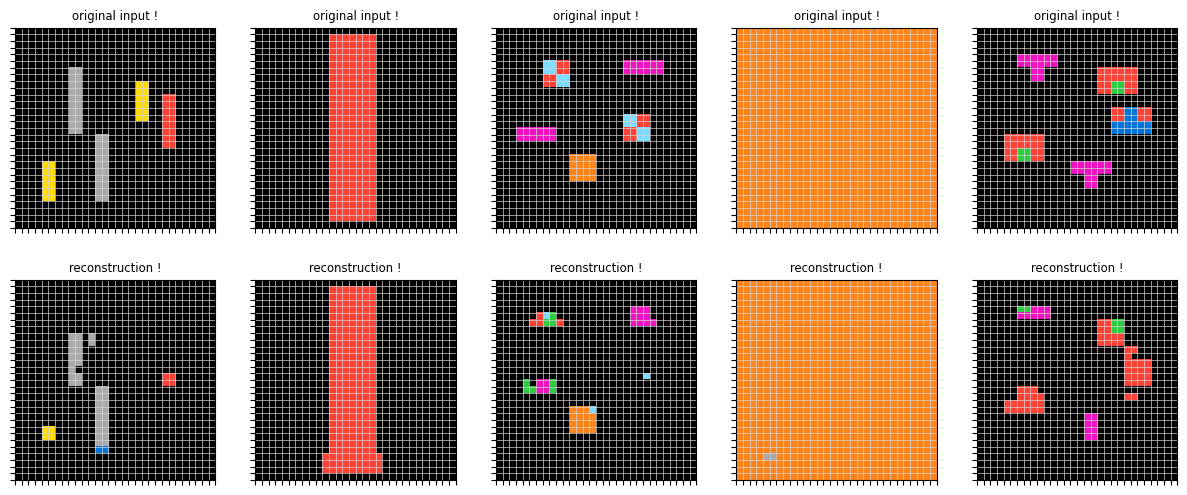

In [27]:
# Visualize five random tasks and their respective reconstructions (output)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
# random.seed(4)
for i in range(5):
    # idx = random.randrange(len(X_inp))
    plot_one(X_inp[i], axs[0,i], i, 'original input')
    plot_one(X_out[i], axs[1,i], i, 'reconstruction')

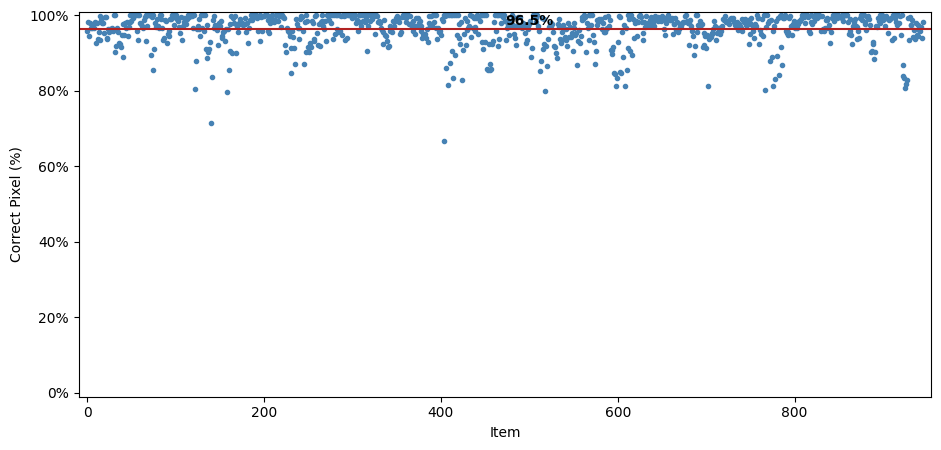

Number of 100% Correct: 148
Number of 90%+ Correct: 885
Number of 80%+ Correct: 942
Number of 70%+ Correct: 945


In [ ]:
# Plot differences between input and output matrices (reconstructions)
plot_pix_acc(X_inp, X_out)

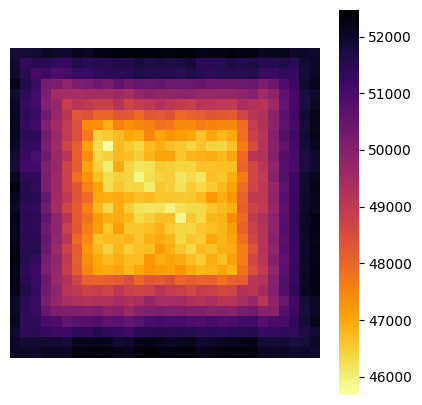

In [ ]:
# Plot heatmap of correct pixel determination by the model (absolute)
plot_pix_heatmap(X_inp, X_out)

## **Visual Analogy Solver (VAS)**

First, let's define the type of data (train vs. evaluation) we want to look at.

In [12]:
# Define the data our VAS is looking at
y_obs = get_all_matrix(y_test) # get the expected output
inp_index = np.insert(np.cumsum([len(i) for i in X_train]), 0, 0) # get the precise index of items

# Define loaders for train (example) and test data
test_loader_few = data_load(X_train, y_train)
test_loader_sol = data_load(X_test, y_test)

# Define lists of solved items per dataset
sol_training = [20, 37, 47, 52, 55, 102, 110, 114, 129, 177, 185, 222, 275, 290, 321, 333, 352, 354, 372, 398] # training data
sol_evaluation = [42, 88, 92, 148, 154, 171, 217, 271, 304, 307, 325, 328, 351, 363] # evaluation/test data
sol_concept = [11, 14, 17, 51, 52, 53, 54, 55, 57, 59, 74, 82, 100, 135] # conceptARC data

# What list to pick based on focus dataset
sol_full = eval("sol_" + focus)

# Load model for model performance
model_vae = torch.load('/content/drive/MyDrive/Thesis_LucaThoms/Models/model_128_bce_4k_2s_wd02.pt', map_location=torch.device(device))

### **Running the Model**

Next, we run the model (VAS). There are two modes to run the model:

1.   Fix latent representation to the mean of the probability distribution:

  `z_inp, _ = model.encode(input.to(device))`

2.   Sample the latent representation, producing (slightly) different solutions for the items in each run:

  `mu, logVar = model.encode(input.to(device))`

  `z_inp = model.reparameterize(mu, logVar)`

Depending on the chosen method, the other one has to be commented out. The below code demonstrates this. There are only three positions where this is necessary (`test_loader_few` input & output representation, `test_loader_sol` input representation).





In [13]:
def visual_analogy(model, test_loader_few, test_loader_sol, inp_index, comp='average'):
    model.eval()
    with torch.no_grad():
        Z_few, Z_few_i, Z_sol, Z_sol_o, Z_sol_p = [[] for _ in range(5)]
        for batch_idx, (input, output) in enumerate(test_loader_few):

            z_inp, _ = model.encode(input.to(device))
            # mu, logVar = model.encode(input.to(device))
            # z_inp = model.reparameterize(mu, logVar)

            z_out, _ = model.encode(output.to(device))
            # mu, logVar = model.encode(output.to(device))
            # z_out = model.reparameterize(mu, logVar)

            z_diff = z_out.cpu().numpy().squeeze() - z_inp.cpu().numpy().squeeze()
            Z_few.append(z_diff)
            Z_few_i.append(z_inp.cpu().numpy().squeeze())

        for batch_idx, (input, output) in enumerate(test_loader_sol):

            z_inp, _ = model.encode(input.to(device))
            # mu, logVar = model.encode(input.to(device))
            # z_inp = model.reparameterize(mu, logVar)

            Z_sol.append(z_inp.cpu().numpy().squeeze())
            Z_sol_o.append(reverse_one_hot_encoder(output.numpy().squeeze()))

        Z_avg, Z_sim, Z_cons, Z_rule = [[] for _ in range(4)]
        for i in range(len(inp_index)-1):

            # Average rule vector
            Z_avg.append(np.mean(Z_few[inp_index[i]:inp_index[i+1]], axis=0))

            # Similarity rule vector (euclidean distance)
            Z_temp = Z_few_i[inp_index[i]:inp_index[i+1]]
            Z_euc = []
            for t in range(len(Z_temp)):
                euclidean_sim = np.linalg.norm(Z_temp[t] - Z_sol[i])
                Z_euc.append(euclidean_sim)
            idx = list(range(inp_index[i], inp_index[i+1]))[Z_euc.index(min(Z_euc))]
            Z_sim.append(Z_few[idx])

            # Check encoding consistency of all rule vectors
            Z_temp = Z_few[inp_index[i]:inp_index[i+1]]
            Z_cons.append(cosine_similarity(Z_temp))

            # Check encoding consistency of two rule vector approaches
            Z_rule.append(np.dot(Z_avg[i], Z_few[idx])/(norm(Z_avg[i])*norm(Z_few[idx])))

        Z_comp = Z_avg if comp == 'average' else Z_sim
        for i in range(len(Z_comp)):
            z_out = Z_sol[i] + Z_comp[i]
            out = model.decode(torch.tensor(z_out, dtype=torch.float32).unsqueeze(0).to(device))
            Z_sol_p.append(reverse_one_hot_encoder(out.cpu().numpy()))

    return Z_sol_o, Z_sol_p, Z_cons, Z_rule


# While loop to keep running until something new got solved
sol = []
sol_full = [] # comment out if you want the model to continue searching (using the previously defined sol_full)
while all(i in sol_full for i in sol):
    Z_sol_o, Z_sol_p, Z_cons, Z_rule = visual_analogy(model_vae, test_loader_few, test_loader_sol, inp_index, comp='average')

    y_pred = []
    for i in range(len(y_obs)):
        y_pred.append(reverse_scaling(y_obs[i], Z_sol_p[i]))

    sol = solved_tasks(y_obs, y_pred)

The approach fully solved:
42, 148, 271, 325, 351, 363
The approach nearly solved:
13, 22, 88, 341, 373


### **Display Predictions**

Next, we visualize the results and in the next chunk we may also investigate the accuracy of the model.

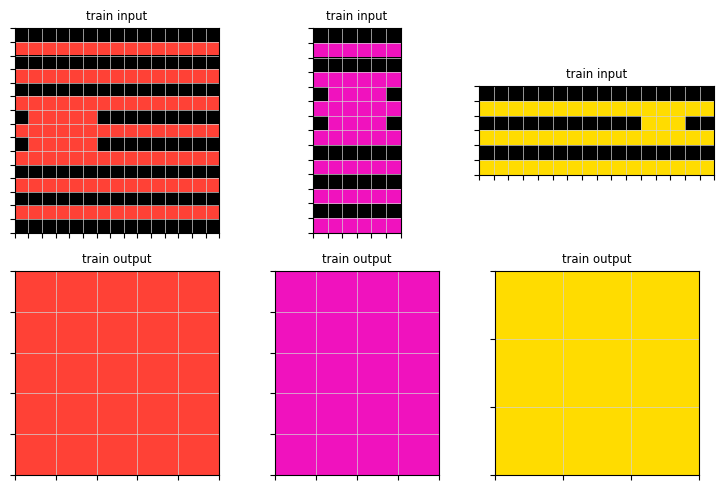

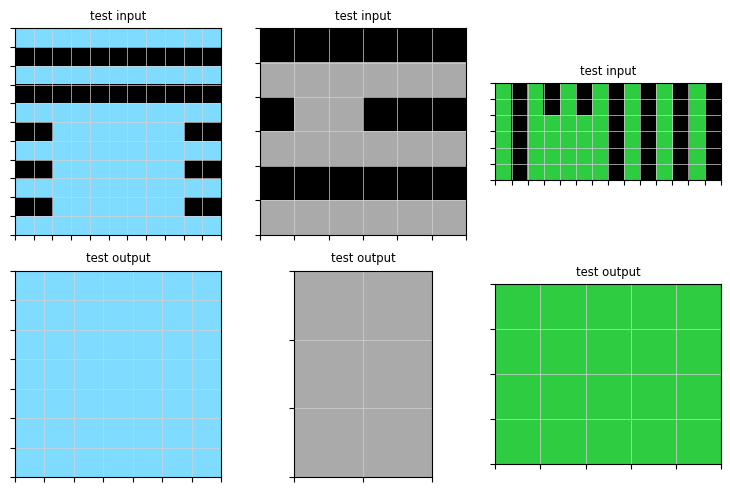

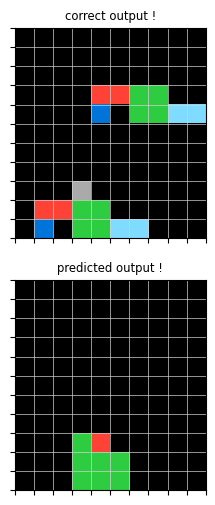

In [75]:
# Choose the item to display the model's solution
idx = 74

# Plot ARC item
plot_ARC(idx, path = 'concept')

# Plot Original and Predicted Output (resized)
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
plot_one(y_obs[idx], axs[0], 0, 'correct output')
plot_one(y_pred[idx], axs[1], 0, 'predicted output')

# Print Ruel Complexity
# print('Encoding Rule Consistency {0:.{1}f}:'.format(Z_rule[idx], 2))
# print(Z_cons[idx])

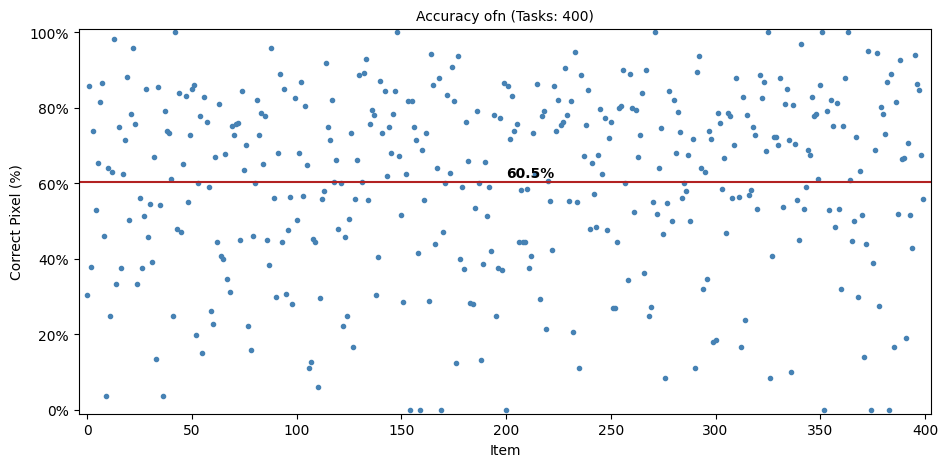

Number of 100% Correct: 6
Number of 90%+ Correct: 24
Number of 80%+ Correct: 92
Number of 70%+ Correct: 172


In [76]:
# Plot differences between original output and predicted output
plot_pix_acc(y_obs, y_pred, exclude_zero=False)

## **Multiple Linear Regression**
Performing multiple regressions to investigate the impact of different task characteristics (e.g., Color Distribution, Background Coverage) on model accuracy. Accuracy is considered using both rule vector approaches (average vs. similarity) and output grid sizes (scaled vs. original).

In [14]:
## Retrieve reconstruction accuarcy for the items in question
# Combine both lists to retrieve indexes for Reconstruction Accuracy
X_inp, X_out = [], []
X_full = [X + y for X, y in zip(X_train, y_train)]
inp_index = np.insert(np.cumsum([len(i) for i in X_full]), 0, 0)
# Create reconstructions for items in questions
rec_loader = data_load(X_train, y_train)
X_inp, X_out = validate(model_vae, rec_loader)
# Calculate reconstruction accuarcy for items in questions
rec_diff = accuracy(X_inp, X_out)
rec_avg = []
for i in range(len(inp_index)-1):
    rec_avg.append(np.mean(rec_diff[inp_index[i]:inp_index[i+1]], axis=0))

## Features for individual grids (input & output) - always calculated as the average per item
item_len = [len(i) for i in X_train] # No. of Examples
col_avg, void_avg, size_avg, cha_avg, sca_avg, size_diff = [[] for _ in range(6)]
for _train in [X_train, y_train]:
    for item in _train:
        col_per, void_per, size_per, ver_per, hor_per, sca_per = [[] for _ in range(6)]
        for i in item:
            col_per.append(len(np.unique(np.array(i))))
            void_per.append(np.count_nonzero(np.array(i) == 0) / np.array(i).size)
            size_per.append(np.array(i).size)
            ver_per.append(np.count_nonzero(np.diff(np.array(i), axis=0)))
            hor_per.append(np.count_nonzero(np.diff(np.array(i), axis=-1)))

            d, _ = scaling(np.array(i), 30, 30, direction='rev')
            sca_per.append(d)

        col_avg.append(np.mean(col_per)) # Average colors (i.e., how many unique colors)
        void_avg.append(np.mean(void_per)) # Average void (i.e., how many zeroes)
        size_avg.append(np.mean(size_per)) # Average size (i.e., "size" or array)
        cha_avg.append(np.mean([sum(x) for x in zip(ver_per, hor_per)])) # Average Rate of Change
        sca_avg.append(np.mean(sca_per)) # Average scaling factor
        size_diff.append(1 if len(set(size_per)) > 1 else 0) # Binary; size differences between grids inputs

## Features for input to output changes - always calculated per item (e.g., average)
col_change, size_change, sim_avg = [[] for _ in range(3)]
for item_x, item_y in zip(X_train, y_train):
    x_sca , y_sca, xy_col, xy_size = [[] for _ in range(4)]
    for x, y in zip(item_x, item_y):
        xy_col.append(set(np.unique(np.array(x))) == set(np.unique(np.array(y))))
        xy_size.append(np.array(x).shape == np.array(y).shape)

        x_sca.append(scaling(np.array(x), 30, 30))
        y_sca.append(scaling(np.array(y), 30, 30))

    col_change.append(0 if all(xy_col) else 1) # Binary; color changes between input to output
    size_change.append(0 if all(xy_size) else 1) # Binary; size changes between input to output
    sim_avg.append(np.mean(accuracy(x_sca, y_sca))) # Average similarity between input and output

## Features for example input to test input changes - always calculated per item
col_change_t, size_change_t = [[] for _ in range(2)]
for item_x, item_t in zip(X_train, X_test):
    flat_list = [i for first_list in item_x for sec_list in first_list for i in sec_list]
    col_full, col_test = set(flat_list), set(np.unique(np.array(item_t[0])))

    xy_size = []
    for x in item_x:
        xy_size.append(np.array(x).shape == np.array(item_t[0]).shape)

    col_change_t.append(0 if all(i in col_full for i in col_test) else 1) # Binary; color changes between input to input
    size_change_t.append(0 if any(xy_size) else 1) # Binary; size changes between input to input

## Dependent Variable: Accuracy (30x30 vs Original)
dep = "30" # or "original"
acc = accuracy(Z_sol_o, Z_sol_p) if dep != "original" else accuracy(y_obs, y_pred) # last accuracy() is "original" size

## Split concatenated features from above (containing input and output features) into halves
feature_split = {}
for feature in ["col_avg", "void_avg", "size_avg", "cha_avg", "sca_avg", "size_diff"]:
    feature_split[f'{feature}_x'], feature_split[f'{feature}_y'] = split_list(eval(feature))

## Create final DataFrame
(data := pd.DataFrame({'Number_Examples': item_len,
                       'Average_Colors_X': feature_split['col_avg_x'],
                       'Average_Colors_Y': feature_split['col_avg_y'],
                       'Average_Zeros_X': feature_split['void_avg_x'],
                       'Average_Zeros_Y': feature_split['void_avg_y'],
                       'Average_Size_X': feature_split['size_avg_x'],
                       'Average_Size_Y': feature_split['size_avg_y'],
                       'Average_RoC_X': feature_split['cha_avg_x'],
                       'Average_RoC_Y': feature_split['cha_avg_y'],
                       'Average_Scale_X': feature_split['sca_avg_x'],
                       'Average_Scale_Y': feature_split['sca_avg_y'],
                       'Average_Reconstruction': rec_avg,
                       'Average_Similarity': sim_avg,
                       'Size_Differences': feature_split['size_diff_x'],
                       'Color_Change': col_change,
                       'Color_Change_T': col_change_t,
                       'Grid_Size_Change': size_change,
                       'Grid_Size_Change_T': size_change_t,
                       'Accuracy': acc}))

,Number_Examples,Average_Colors_X,Average_Colors_Y,Average_Zeros_X,Average_Zeros_Y,Average_Size_X,Average_Size_Y,Average_RoC_X,Average_RoC_Y,Average_Scale_X,Average_Scale_Y,Average_Reconstruction,Average_Similarity,Size_Differences,Color_Change,Color_Change_T,Grid_Size_Change,Grid_Size_Change_T,Accuracy
0,2,3.500000,3.500000,0.000000,0.000000,4.00,36.00,4.000000,57.000000,15.00,5.00,0.832222,0.361111,0,0,1,1,0,0.294444
1,5,3.000000,2.000000,0.854082,0.882653,196.00,196.00,66.600000,51.400000,2.00,2.00,0.940889,0.872889,0,1,0,0,0,0.868889
2,4,2.000000,3.500000,0.718419,0.493969,131.00,131.00,55.250000,55.250000,2.75,2.75,0.954028,0.806667,1,1,0,0,1,0.724444
3,3,4.333333,4.333333,0.793333,0.816667,100.00,100.00,21.000000,23.666667,3.00,3.00,0.973333,0.620000,0,0,1,0,0,0.748889
4,3,4.000000,5.000000,0.891111,0.656667,900.00,900.00,176.333333,325.333333,1.00,1.00,0.871852,0.725926,0,1,0,0,0,0.528889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2,6.000000,6.000000,0.000000,0.000000,530.00,530.00,54.000000,100.000000,1.00,1.00,0.972500,0.982222,1,0,1,0,1,0.940000
396,3,2.000000,3.000000,0.986122,0.836827,487.00,487.00,11.333333,124.666667,1.00,1.00,0.960000,0.920000,1,1,0,0,0,0.961111
397,2,2.000000,5.000000,0.956845,0.689881,116.00,116.00,12.000000,96.000000,1.50,1.50,0.949167,0.910556,1,1,0,0,1,0.913333
398,3,2.000000,4.000000,0.636364,0.636364,176.00,176.00,128.000000,128.000000,1.00,1.00,0.945926,0.963333,0,1,0,0,0,0.936667


In [15]:
# Define predictors and dependent variable (standardized)
X = zscore(data.iloc[:, 0:-1])
y = zscore(data['Accuracy'])

# Check for Multicollinarity
vif_data = pd.DataFrame({"Feature": X.columns,
                         "VIF": [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]})

# Fit model with standardized features
estimates = sm.OLS(y, sm.add_constant(X)).fit()

# Run LASSO as additional feature selection (to stepwise & RFECV)
lasso = sm.OLS(y, X).fit_regularized(alpha=0.1, L1_wt=1)

# Run cross-validated Recursive Feature Elimination (RFE)
rfe_mod =  RFECV(LinearRegression(), min_features_to_select=5, cv=300)
rfe_ranked = pd.DataFrame({"Feature": X.columns,
                           "Rank": rfe_mod.fit(X, y).ranking_})

print(estimates.summary())
print('==============================================================================\n          Feature Selection\n')
print('Features based on forward stepwise regression:')
print(*forward_regression(X, y, threshold_in=0.01), sep = ', ')

print('\nFeatures based on backward stepwise regression:')
print(*backward_regression(X, y, threshold_out=0.01), sep = ', ')

print('\nFeatures based on cross-validated recursive feature elimination:')
print(*rfe_ranked[rfe_ranked['Rank']==1]['Feature'].tolist(), sep = ', ')

print('==============================================================================\n               Lasso\n', lasso.params)
# print('==============================================================================\n          Multicollinearity\n', vif_data.to_string(index=False))

                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     54.24
Date:                Fri, 01 Sep 2023   Prob (F-statistic):           2.95e-93
Time:                        17:23:46   Log-Likelihood:                -313.49
No. Observations:                 400   AIC:                             665.0
Df Residuals:                     381   BIC:                             740.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -5.27

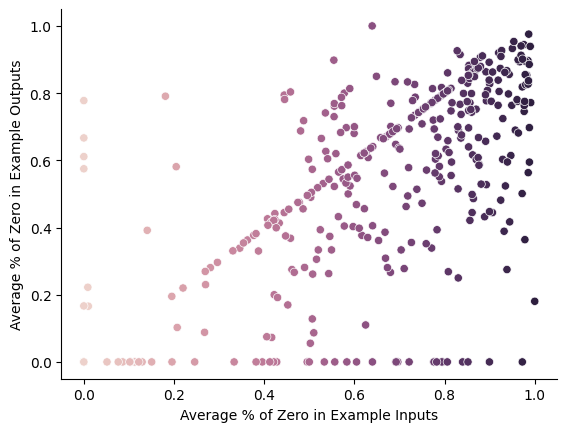

In [ ]:
sns.scatterplot(
    data=data,
    x="Average_Zeros_X",
    y="Average_Zeros_Y",
    hue="Average_Zeros_X",
    legend=None)
sns.despine()
plt.xlabel('Average % of Zero in Example Inputs')
plt.ylabel('Average % of Zero in Example Outputs')
plt.show();

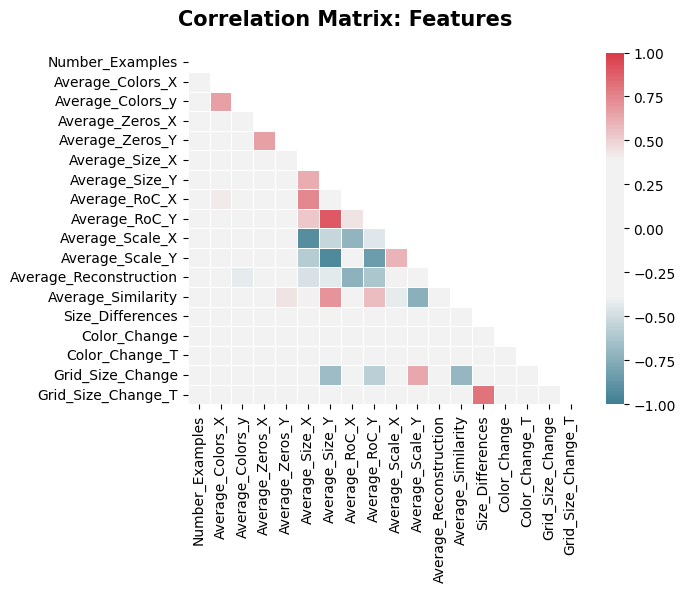

In [ ]:
X = data.iloc[:, 0:-1]
corr = X.corr(method='spearman')

# Generate mask for upper triangle (just symmetric)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Create custom colormap to highlight pos. & neg. correlations
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

# Draw heatmap (/w mask & colormap)
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)
fig.suptitle('Correlation Matrix: Features', fontsize=15, weight='bold')
fig.tight_layout()

## **Appendix**

Solved ConceptARC items based on rule vector approach. For every concept category, we calculated the solved fraction of items (out of 30).

In [ ]:
# Average Rule Vector
# [11, 14, 51, 52, 53, 54, 55, 59, 100, 135] on 1st test input
# [22, 23, 40, 51, 52, 54, 55, 57, 59, 74, 78, 100] on 2nd test input
# [51, 52, 55, 59, 82, 100, 121, 138] on 3rd test input

# 'AboveBelow (0-9)': 0
# 'Center' (10-19): 2/30 = 0.07
# 'CleanUp' (20-29): 2/30 = 0.07
# 'CompleteShape' (30-39): 0
# 'Copy' (40-49): 1/30 = 0.03
# 'Count' (50-59): 16/30 = 0.53
# 'ExtendToBoundary' (60-69): 0
# 'ExtractObjects' (70-79): 2/30 = 0.07
# 'FilledNotFilled' (80-89): 1/30 = 0.03
# 'HorizontalVertical' (90-99): 0
# 'InsideOutside' (100-109): 3/30 = 0.1
# 'MoveToBoundary' (110-119): 0
# 'Order' (120-129): 1/30 = 0.03
# 'SameDifferent' (130-139): 2/30 = 0.07
# 'TopBottom2D' (140-149): 0
# 'TopBottom3D' (150-159): 0


# Similarity Rule Vector
# [14, 51, 52, 53, 54, 55, 59, 147] on 1st test input
# [23, 51, 52, 53, 54, 55, 59, 74, 78, 100, 135, 140] on 2nd test input
# [51, 52, 53, 54, 55, 59, 82, 138] on 3rd test input

# 'AboveBelow (0-9)': 0
# 'Center' (10-19): 1/30 = 0.03
# 'CleanUp' (20-29): 1/30 = 0.03
# 'CompleteShape' (30-39): 0
# 'Copy' (40-49): 0
# 'Count' (50-59): 18/30 = 0.6
# 'ExtendToBoundary' (60-69): 0
# 'ExtractObjects' (70-79): 2/30 = 0.07
# 'FilledNotFilled' (80-89): 1/30 = 0.03
# 'HorizontalVertical' (90-99): 0
# 'InsideOutside' (100-109): 1/30 = 0.03
# 'MoveToBoundary' (110-119): 0
# 'Order' (120-129): 0
# 'SameDifferent' (130-139): 2/30 = 0.07
# 'TopBottom2D' (140-149): 2/30 = 0.07
# 'TopBottom3D' (150-159): 0